In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 2 — Basics of Data and Preprocessing
## Lesson 1: Understanding Data Types and Structures

**Course:** Introductory Course of Machine Learning (Tabular / Classical Track)  
**Goal of this lesson:** build a practical mental model of *what kinds of data you can have* and *how those data are represented in Python and in ML toolchains*.

This lesson is intentionally hands-on: you will inspect real CSV-style datasets, validate and convert data types, and connect “data type choices” to downstream modeling, metrics, and computational cost.


In [2]:
# Core imports used throughout the lesson
import numpy as np
import pandas as pd

from pathlib import Path
import random

import matplotlib.pyplot as plt

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Environment ready. RANDOM_SEED =", RANDOM_SEED)


Environment ready. RANDOM_SEED = 42


In [3]:
LANG = "en"

def T(en: str, fa: str) -> str:
    return fa if LANG == "fa" else en

print(T("Environment ready.", "محیط آماده است."), "RANDOM_SEED =", 42)


Environment ready. RANDOM_SEED = 42


In [4]:
# Dataset paths (relative to this notebook location: Tutorials/<Language>/Chapter2)
from pathlib import Path

DATASETS = {
    "iris": Path("../../../Datasets/Classification/iris.csv"),
    "house_prices": Path("../../../Datasets/Regression/house-prices.csv"),
    "listings": Path("../../../Datasets/Regression/listings.csv"),
    "airports": Path("../../../Datasets/Clustering/airports.csv"),
    "hw_200": Path("../../../Datasets/Clustering/hw_200.csv"),
    "earthquake": Path("../../../Datasets/Regression/earthquake.csv"),
}

def load_csv(key: str, **read_csv_kwargs) -> pd.DataFrame:
    return pd.read_csv(DATASETS[key], **read_csv_kwargs)

# Quick sanity: show a couple of resolved paths
for k in ["iris", "house_prices", "airports"]:
    p = DATASETS[k]
    print(k, "->", p, "| exists:", p.exists())


iris -> ..\..\..\Datasets\Classification\iris.csv | exists: True
house_prices -> ..\..\..\Datasets\Regression\house-prices.csv | exists: True
airports -> ..\..\..\Datasets\Clustering\airports.csv | exists: True


### Learning objectives

By the end of this lesson, you should be able to:

1. Distinguish **measurement scales** (nominal / ordinal / interval / ratio) and map them to ML features.
2. Audit a dataset for **numeric**, **categorical**, **boolean**, **text**, **datetime**, and **geospatial** columns.
3. Explain common data structures used in ML: scalars, vectors, matrices, tensors, tables, sparse matrices.
4. Use Python + NumPy + pandas to **inspect**, **convert**, and **validate** dtypes.
5. Make informed trade-offs between correctness, memory, and speed (e.g., `category` vs `object`, `float32` vs `float64`).


## 1) Data types in ML: not just “int vs float”

A “data type” is more than a storage format. In an ML pipeline, a data type determines:

- **What operations are meaningful** (ordering? averaging? distance?).
- **Which models can consume it** (linear models need numeric arrays; trees can handle ordinal encodings; some methods handle text via vectorization).
- **How errors appear** (silent casting, NaNs from parsing, category explosions after one-hot encoding).
- **Compute and memory** (e.g., `float32` halves memory vs `float64`, categories can compress repeated strings).

A useful classification is the **measurement scale**:

- **Nominal:** names/labels, no ordering (city, color, product type).
- **Ordinal:** ordered categories (small/medium/large, education level).
- **Interval:** differences meaningful, zero arbitrary (temperature in °C).
- **Ratio:** differences + a true zero (length, weight, price).

In tabular ML, most models ultimately consume a numeric matrix:

$$X \in \mathbb{R}^{n \times d}, \quad y \in \mathcal{Y}$$

…but how you *encode* different column types into $X$ matters.


## 2) Data structures: from scalars to tables (and why shapes matter)

Most ML libraries think in terms of arrays with explicit shapes:

- **Scalar:** a single value, e.g., $x \in \mathbb{R}$.
- **Vector:** $\mathbf{x} \in \mathbb{R}^{d}$ (one sample with $d$ features).
- **Matrix:** $X \in \mathbb{R}^{n \times d}$ (tabular dataset).
- **Tensor:** higher-dimensional arrays, e.g., $\mathbb{R}^{n \times t \times d}$ for sequences.

Tabular data is typically held in a **DataFrame**, but the underlying computations often happen on:

- NumPy arrays (`ndarray`)
- SciPy sparse matrices (useful when $X$ is mostly zeros after one-hot encoding)
- Specialized columnar formats (Parquet/Arrow) in production

A practical habit: always confirm **shape** and **dtype** before modeling.


## 3) Python types vs NumPy dtypes vs pandas dtypes

It is common to confuse three layers:

- **Python types** (`int`, `float`, `str`, `list`, `dict`) are flexible but not memory efficient for large arrays.
- **NumPy dtypes** (`int64`, `float32`, `datetime64[ns]`) are fixed-size, vectorized, and fast.
- **pandas dtypes** are built on NumPy + extension types (`category`, `string`, `Int64`, `boolean`).

A single DataFrame can mix multiple dtypes column-wise, which is ideal for tabular data.

Key practical point: a pandas column with dtype `object` is often a sign that you have **mixed types** or **strings** stored in a generic container. Converting to `category`, `string`, or numeric often improves correctness and efficiency.


In [5]:
# Python types: scalars and container structures
a = 7
b = 3.14
c = True
d = "ML"

lst = [1, 2, 3]
tpl = (1, 2, 3)
st = {1, 2, 3}
mp = {"feature": "sepal_length", "value": 5.4}

objects = [a, b, c, d, lst, tpl, st, mp]
for obj in objects:
    print(f"{repr(obj):>35}  ->  type: {type(obj)}")


                                  7  ->  type: <class 'int'>
                               3.14  ->  type: <class 'float'>
                               True  ->  type: <class 'bool'>
                               'ML'  ->  type: <class 'str'>
                          [1, 2, 3]  ->  type: <class 'list'>
                          (1, 2, 3)  ->  type: <class 'tuple'>
                          {1, 2, 3}  ->  type: <class 'set'>
{'feature': 'sepal_length', 'value': 5.4}  ->  type: <class 'dict'>


In [6]:
# NumPy dtype and shape fundamentals
x = np.array([1, 2, 3])
y = np.array([1, 2, 3], dtype=np.float32)

X = np.array([[1, 2, 3],
              [4, 5, 6]], dtype=np.int32)

print("x:", x, "dtype:", x.dtype, "shape:", x.shape)
print("y:", y, "dtype:", y.dtype, "shape:", y.shape)
print("X:\n", X)
print("X dtype:", X.dtype, "shape:", X.shape)
print("X nbytes:", X.nbytes)


x: [1 2 3] dtype: int64 shape: (3,)
y: [1. 2. 3.] dtype: float32 shape: (3,)
X:
 [[1 2 3]
 [4 5 6]]
X dtype: int32 shape: (2, 3)
X nbytes: 24


## 4) A real dataset dtype audit (mixed columns)

Let’s load several datasets with different “type signatures”:

- **Iris** (mostly numeric + categorical label)
- **House Prices** (numeric + binary + nominal categories)
- **Listings** (numeric + text + missing values + date)
- **Airports** (IDs, codes, mixed strings, numeric geo fields)
- **HW_200** (a deliberately messy header to show why types and parsing matter)

We will:

1. Display `head()`
2. Use `info()` to see inferred dtypes
3. Measure memory usage
4. Convert a few columns into more appropriate types


In [7]:
# Load datasets
iris = load_csv("iris")
house = load_csv("house_prices")
listings = load_csv("listings")
airports = load_csv("airports")
hw = load_csv("hw_200")

datasets = {
    "iris": iris,
    "house_prices": house,
    "listings": listings,
    "airports": airports,
    "hw_200": hw,
}

for name, df in datasets.items():
    print("\n" + "="*80)
    print("Dataset:", name, "| shape:", df.shape)
    display(df.head())



Dataset: iris | shape: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa



Dataset: house_prices | shape: (128, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East



Dataset: listings | shape: (94559, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN



Dataset: airports | shape: (83125, 19)


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN



Dataset: hw_200 | shape: (200, 3)


,Index,"Height(Inches)""","""Weight(Pounds)"""
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


In [8]:
import io

def dtype_audit(df: pd.DataFrame, name: str):
    print("\n" + "-"*80)
    print("Audit:", name)
    display(df.dtypes.to_frame("dtype").T)

    sio = io.StringIO()
    df.info(buf=sio)
    print(sio.getvalue())

    mem = df.memory_usage(deep=True).sum()
    print("Approx. memory (bytes):", int(mem))
    print("Approx. memory (KB):", round(mem/1024, 2))

for name, df in datasets.items():
    dtype_audit(df, name)



--------------------------------------------------------------------------------
Audit: iris


,sepal_length,sepal_width,petal_length,petal_width,classification
dtype,float64,float64,float64,float64,object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sepal_length    150 non-null    float64
 1   sepal_width     150 non-null    float64
 2   petal_length    150 non-null    float64
 3   petal_width     150 non-null    float64
 4   classification  150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB

Approx. memory (bytes): 14282
Approx. memory (KB): 13.95

--------------------------------------------------------------------------------
Audit: house_prices


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
dtype,int64,int64,int64,int64,int64,int64,object,object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Home          128 non-null    int64 
 1   Price         128 non-null    int64 
 2   SqFt          128 non-null    int64 
 3   Bedrooms      128 non-null    int64 
 4   Bathrooms     128 non-null    int64 
 5   Offers        128 non-null    int64 
 6   Brick         128 non-null    object
 7   Neighborhood  128 non-null    object
dtypes: int64(6), object(2)
memory usage: 8.1+ KB

Approx. memory (bytes): 19674
Approx. memory (KB): 19.21

--------------------------------------------------------------------------------
Audit: listings


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
dtype,int64,object,int64,object,float64,object,float64,float64,object,float64,int64,int64,object,float64,int64,int64,int64,float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94559 entries, 0 to 94558
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              94559 non-null  int64  
 1   name                            94559 non-null  object 
 2   host_id                         94559 non-null  int64  
 3   host_name                       94506 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   94559 non-null  object 
 6   latitude                        94559 non-null  float64
 7   longitude                       94559 non-null  float64
 8   room_type                       94559 non-null  object 
 9   price                           60341 non-null  float64
 10  minimum_nights                  94559 non-null  int64  
 11  number_of_reviews               94559 non-null  int64  
 12  last_review                     

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
dtype,int64,object,object,object,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83125 entries, 0 to 83124
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 83125 non-null  int64  
 1   ident              83125 non-null  object 
 2   type               83125 non-null  object 
 3   name               83125 non-null  object 
 4   latitude_deg       83125 non-null  float64
 5   longitude_deg      83125 non-null  float64
 6   elevation_ft       68641 non-null  float64
 7   continent          43963 non-null  object 
 8   iso_country        82857 non-null  object 
 9   iso_region         83125 non-null  object 
 10  municipality       78437 non-null  object 
 11  scheduled_service  83125 non-null  object 
 12  icao_code          8637 non-null   object 
 13  iata_code          9079 non-null   object 
 14  gps_code           43288 non-null  object 
 15  local_code         35667 non-null  object 
 16  home_link          430

,Index,"Height(Inches)""","""Weight(Pounds)"""
dtype,int64,float64,float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Index              200 non-null    int64  
 1    Height(Inches)"   200 non-null    float64
 2    "Weight(Pounds)"  200 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.8 KB

Approx. memory (bytes): 4932
Approx. memory (KB): 4.82


## 4.1) Quick visualization to connect types to EDA

Even in a “types” lesson, plotting helps:

- Numeric columns → histograms, boxplots
- Categorical columns → bar charts
- Numeric vs numeric → scatterplots

We will plot a histogram and a scatterplot for the iris dataset.


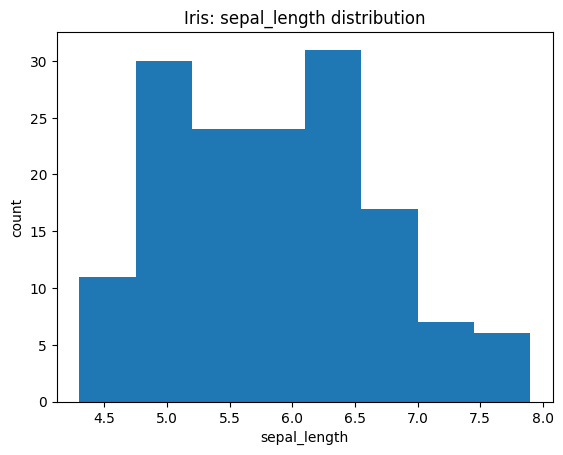

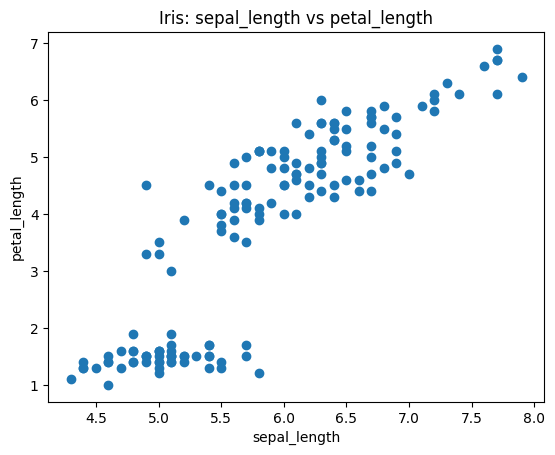

In [9]:
iris_num = iris.copy()

plt.figure()
iris_num["sepal_length"] = pd.to_numeric(iris_num["sepal_length"], errors="coerce")
plt.hist(iris_num["sepal_length"].dropna(), bins=8)
plt.title(T("Iris: sepal_length distribution", "Iris: توزیع sepal_length"))
plt.xlabel(T("sepal_length", "sepal_length"))
plt.ylabel(T("count", "تعداد"))
plt.show()

plt.figure()
plt.scatter(iris_num["sepal_length"], pd.to_numeric(iris_num["petal_length"], errors="coerce"))
plt.title(T("Iris: sepal_length vs petal_length", "Iris: sepal_length در برابر petal_length"))
plt.xlabel(T("sepal_length", "sepal_length"))
plt.ylabel(T("petal_length", "petal_length"))
plt.show()


## 5) Converting column types: correctness + performance

### 5.1 Categorical columns

If a column has a small set of repeating strings (e.g., `Neighborhood`, `room_type`), `category` is often better than `object`:

- Saves memory (dictionary encoding)
- Makes legal values explicit (good for validation)
- Helps prevent silent typos (“Eats” vs “East”)

### 5.2 Integers with missing values

In pandas, a plain `int64` column cannot hold missing values. If you need missingness, use the nullable integer dtype: `Int64` (capital I).

### 5.3 Datetimes

Dates are not strings. When a column is “time-like”, parse it to `datetime64[ns]` so that comparisons, sorting, resampling, and time-deltas work correctly.

We will apply these conversions to two datasets.


In [10]:
# --- House prices: convert a few obvious categories ---
house2 = house.copy()

house2["Brick"] = house2["Brick"].astype("category")
house2["Neighborhood"] = house2["Neighborhood"].astype("category")

# Ensure numeric columns are numeric
for col in ["Price", "SqFt", "Bedrooms", "Bathrooms", "Offers"]:
    house2[col] = pd.to_numeric(house2[col], errors="coerce")

print("Before:")
display(house.dtypes.to_frame("dtype").T)
print("After:")
display(house2.dtypes.to_frame("dtype").T)

print("Memory before (bytes):", int(house.memory_usage(deep=True).sum()))
print("Memory after  (bytes):", int(house2.memory_usage(deep=True).sum()))


Before:


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
dtype,int64,int64,int64,int64,int64,int64,object,object


After:


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
dtype,int64,int64,int64,int64,int64,int64,category,category


Memory before (bytes): 19674
Memory after  (bytes): 7011


In [11]:
# --- Listings: parse dates, numeric, categories ---
lst2 = listings.copy()

# Parse last_review to datetime
lst2["last_review"] = pd.to_datetime(lst2["last_review"], errors="coerce")

# price is numeric but has missing values -> float
lst2["price"] = pd.to_numeric(lst2["price"], errors="coerce")

# categorical columns
for col in ["neighbourhood", "room_type", "host_name"]:
    lst2[col] = lst2[col].astype("category")

print("Dtypes after conversions:")
display(lst2.dtypes.to_frame("dtype").T)

# Quick checks
print("last_review min/max:", lst2["last_review"].min(), "/", lst2["last_review"].max())
print("price has NaN count:", int(lst2["price"].isna().sum()))


Dtypes after conversions:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
dtype,int64,object,int64,category,float64,category,float64,float64,category,float64,int64,int64,datetime64[ns],float64,int64,int64,int64,float64


last_review min/max: 2011-07-02 00:00:00 / 2025-03-15 00:00:00
price has NaN count: 34218


## 6) When dtypes go wrong: a “messy header” example

Real-world CSVs are often messy: extra quotes, trailing spaces, weird symbols, or inconsistent naming.

A classic symptom is a downstream error like `KeyError: 'Height(Inches)'` because the actual column name has hidden characters.

We will inspect the column names in `hw_200` and then normalize them:

- Strip whitespace
- Remove quotes
- Replace repeated spaces
- Standardize to a safe identifier style

This is a *data structure* issue: your table schema (column names + dtypes) is part of the data.


In [12]:
import re

hw2 = hw.copy()

print("Raw columns:")
for col in hw2.columns:
    print(repr(col))

def clean_col(name: str) -> str:
    name = name.strip()
    name = name.replace('"', "")
    name = re.sub(r"\s+", " ", name)
    # remove spaces around punctuation
    name = name.replace(" (", "(").replace(") ", ")")
    return name

hw2.columns = [clean_col(c) for c in hw2.columns]

print("\nCleaned columns:")
for col in hw2.columns:
    print(repr(col))

display(hw2.head())

# Coerce numeric columns
for col in hw2.columns:
    hw2[col] = pd.to_numeric(hw2[col], errors="coerce")

display(hw2.dtypes.to_frame("dtype").T)


Raw columns:
'Index'
' Height(Inches)"'
' "Weight(Pounds)"'

Cleaned columns:
'Index'
'Height(Inches)'
'Weight(Pounds)'


,Index,Height(Inches),Weight(Pounds)
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


,Index,Height(Inches),Weight(Pounds)
dtype,int64,float64,float64


## 7) A closer look at “text” features (object vs string vs category)

In pandas:

- `object` historically stores arbitrary Python objects, commonly strings.
- `string` (pandas StringDtype) is a dedicated string dtype with better missing value handling.
- `category` is a dictionary-encoded representation suitable when the set of unique values is limited.

Rule of thumb:

- Free-form text (reviews, narratives) → keep as `string` (later vectorize to numeric).
- Small vocabulary labels (city names, product types) → use `category`.
- Mixed or messy fields → audit first (`object` is a red flag).

We will compare memory usage for these choices on a toy example derived from the listings dataset.


In [13]:
toy = pd.DataFrame({
    "neighbourhood": listings["neighbourhood"].astype("object"),
    "host_name": listings["host_name"].astype("object"),
})

toy_obj = toy.copy()
toy_str = toy.copy()
toy_cat = toy.copy()

toy_str["neighbourhood"] = toy_str["neighbourhood"].astype("string")
toy_str["host_name"] = toy_str["host_name"].astype("string")

toy_cat["neighbourhood"] = toy_cat["neighbourhood"].astype("category")
toy_cat["host_name"] = toy_cat["host_name"].astype("category")

def mem(df): 
    return int(df.memory_usage(deep=True).sum())

out = pd.DataFrame({
    "object": [mem(toy_obj)],
    "string": [mem(toy_str)],
    "category": [mem(toy_cat)],
}, index=["memory_bytes"]).T

display(out)


,memory_bytes
object,10882329
string,10883601
category,1747934


## 8) Numeric precision and stability: `float32` vs `float64`

Many ML models and preprocessing steps are numerically sensitive. Precision choices can matter:

- `float64` is usually the safest default in scientific Python.
- `float32` halves memory and can be faster, but may accumulate rounding error.

A practical approach:

1. Keep raw data as `float64` during exploration and validation.
2. Consider `float32` for large datasets once you have stable pipelines and monitoring.

We demonstrate precision effects on a simple computation: summing many small numbers.


In [14]:
n = 2_000_000
small = np.full(n, 1e-6, dtype=np.float64)
small32 = small.astype(np.float32)

s64 = small.sum()
s32 = small32.sum()

print("Expected:", n * 1e-6)
print("float64 sum:", s64, "abs error:", abs(s64 - n*1e-6))
print("float32 sum:", float(s32), "abs error:", abs(float(s32) - n*1e-6))


Expected: 2.0
float64 sum: 1.9999999999999953 abs error: 4.6629367034256575e-15
float32 sum: 1.9999934434890747 abs error: 6.556510925292969e-06


## 9) Datetime structures: combine date + time, compute time deltas

Time series modeling and even basic EDA require correct datetime types.

In `earthquake.csv` we have separate `date` and `time` columns. We will:

1. Parse them
2. Combine into a single timestamp
3. Compute time deltas between consecutive events (after sorting)

This illustrates why datetimes are a distinct type, not just text.


In [15]:
eq = load_csv("earthquake")

eq["timestamp"] = pd.to_datetime(eq["date"] + " " + eq["time"], errors="coerce")
eq = eq.sort_values("timestamp").reset_index(drop=True)

eq["delta_minutes"] = eq["timestamp"].diff().dt.total_seconds() / 60.0

display(eq[["date", "time", "timestamp", "delta_minutes", "magnitude"]])

print("timestamp dtype:", eq["timestamp"].dtype)
print("Mean delta (minutes):", round(eq["delta_minutes"].mean(skipna=True), 3))


,date,time,timestamp,delta_minutes,magnitude
0,2008-11-01,00:31:25,2008-11-01 00:31:25,NaN,2.99
1,2008-11-01,01:34:29,2008-11-01 01:34:29,63.066667,5.51
2,2008-11-01,01:38:14,2008-11-01 01:38:14,3.750000,3.54
3,2008-11-01,02:20:05,2008-11-01 02:20:05,41.850000,2.42
4,2008-11-01,02:32:18,2008-11-01 02:32:18,12.216667,2.41
...,...,...,...,...,...
87367,2022-09-26,22:00:50,2022-09-26 22:00:50,108.583333,3.41
87368,2022-09-26,22:08:59,2022-09-26 22:08:59,8.150000,3.29
87369,2022-09-26,22:11:43,2022-09-26 22:11:43,2.733333,3.38
87370,2022-09-26,22:53:16,2022-09-26 22:53:16,41.550000,3.49


timestamp dtype: datetime64[ns]
Mean delta (minutes): 83.692


## 10) Geospatial columns: latitude/longitude are numeric, but *they encode geometry*

Latitude/longitude are floats, but they are not “generic numbers.” Operations like Euclidean distance on degrees can be misleading.

A common lightweight approach is the Haversine formula for great-circle distance:

$$d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\varphi}{2}\right) + \cos(\varphi_1)\cos(\varphi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)$$

We will compute approximate distances between a few airports to show how numeric columns can carry domain semantics.


In [16]:
air = airports.copy()

# Ensure numeric
air["latitude_deg"] = pd.to_numeric(air["latitude_deg"], errors="coerce")
air["longitude_deg"] = pd.to_numeric(air["longitude_deg"], errors="coerce")

# Pick a few airports with valid coords
sample_air = air.dropna(subset=["latitude_deg", "longitude_deg"]).head(4).reset_index(drop=True)
display(sample_air[["ident", "name", "latitude_deg", "longitude_deg", "iso_region"]])

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*(np.sin(dlmb/2)**2)
    return 2*R*np.arcsin(np.sqrt(a))

pairs = []
for i in range(len(sample_air)):
    for j in range(i+1, len(sample_air)):
        d = haversine_km(sample_air.loc[i,"latitude_deg"], sample_air.loc[i,"longitude_deg"],
                         sample_air.loc[j,"latitude_deg"], sample_air.loc[j,"longitude_deg"])
        pairs.append((sample_air.loc[i,"ident"], sample_air.loc[j,"ident"], d))

dist_df = pd.DataFrame(pairs, columns=["from", "to", "distance_km"])
display(dist_df)


,ident,name,latitude_deg,longitude_deg,iso_region
0,00A,Total RF Heliport,40.070985,-74.933689,US-PA
1,00AA,Aero B Ranch Airport,38.704022,-101.473911,US-KS
2,00AK,Lowell Field,59.947733,-151.692524,US-AK
3,00AL,Epps Airpark,34.864799,-86.770302,US-AL


,from,to,distance_km
0,00A,00AA,2277.457507
1,00A,00AK,5541.519489
2,00A,00AL,1192.845305
3,00AA,00AK,4191.236344
4,00AA,00AL,1375.413553
5,00AK,00AL,5338.865869


## 11) Sparse vs dense: when one-hot encoding explodes the feature space

Categorical variables are often encoded into numeric matrices using one-hot encoding.

If a column has $k$ unique categories, one-hot creates $k$ binary features. For multiple high-cardinality columns, $d$ can become very large, and the matrix is often mostly zeros.

Sparse matrices store only non-zero entries and can be dramatically more memory efficient.

We will build a tiny one-hot example and compare dense vs sparse representations.


In [17]:
from scipy import sparse

cats = pd.Series(["East","East","North","West","East","West","South","South","East","North"], name="Neighborhood")
onehot = pd.get_dummies(cats)

dense = onehot.to_numpy(dtype=np.int8)
sp = sparse.csr_matrix(dense)

print("One-hot shape:", dense.shape)
print("Dense nbytes:", dense.nbytes)
print("Sparse nnz (non-zeros):", sp.nnz)
print("Sparse data nbytes:", sp.data.nbytes)

display(onehot.head())


One-hot shape: (10, 4)
Dense nbytes: 40
Sparse nnz (non-zeros): 10
Sparse data nbytes: 10


,East,North,South,West
0,True,False,False,False
1,True,False,False,False
2,False,True,False,False
3,False,False,False,True
4,True,False,False,False


## 12) Practical checklist: dtype and structure sanity before modeling

Before you train a model, enforce a minimum checklist:

1. **Schema clarity**
   - Column names are consistent and clean.
   - Each column has a declared “meaning” and expected dtype.

2. **Type correctness**
   - Numeric columns are numeric (`int`, `float`), not strings.
   - Categories are categories (or explicitly encoded).
   - Datetimes are parsed and timezone policy is known.

3. **Missing values policy**
   - You know which columns can be missing and why.
   - Missingness is represented consistently (NaN / NA).

4. **Shape discipline**
   - Features matrix $X$ is $n \times d$ and labels $y$ is length $n$.
   - No accidental index leakage (e.g., using row IDs as a feature).

5. **Memory and performance**
   - Convert obvious categories; avoid accidental `object` dtypes for large columns.
   - Consider sparse matrices for one-hot, especially at scale.

Below, we package a small dtype-report utility you can reuse.


In [18]:
def dtype_report(df: pd.DataFrame) -> pd.DataFrame:
    example = df.head(3).apply(lambda s: ", ".join([str(v) for v in s.tolist()]), axis=0)
    rep = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_missing": df.isna().sum(),
        "missing_rate": (df.isna().mean()).round(3),
        "n_unique": df.nunique(dropna=True),
        "example_values": example,
    })
    rep = rep.sort_values(["dtype", "n_unique"])
    return rep

report_listings = dtype_report(lst2)
display(report_listings.head(20))


,dtype,n_missing,missing_rate,n_unique,example_values
room_type,category,0,0.000,4,"Private room, Entire home/apt, Entire home/apt"
neighbourhood,category,0,0.000,33,"Islington, Kensington and Chelsea, Westminster"
host_name,category,53,0.001,16416,"Alina, Philippa, Liz"
last_review,datetime64[ns],24242,0.256,3444,"2025-02-09 00:00:00, 2024-04-28 00:00:00, 2024..."
neighbourhood_group,float64,94559,1.000,0,"nan, nan, nan"
license,float64,94559,1.000,0,"nan, nan, nan"
reviews_per_month,float64,24242,0.256,868,"0.29, 0.52, 0.33"
price,float64,34218,0.362,1239,"57.0, nan, 510.0"
latitude,float64,0,0.000,52417,"51.56861, 51.4878, 51.52195"
longitude,float64,0,0.000,61792,"-0.1127, -0.16813, -0.14094"


## 13) Mini-exercises (with solutions)

### Exercise A — Identify and convert types
From `listings`:

1. Convert `room_type` to `category`.
2. Convert `price` to numeric.
3. Convert `last_review` to datetime.
4. Report memory usage before and after.

### Exercise B — Shape discipline
Create $X$ and $y$ for the iris dataset where:

- $X$ contains the four numeric columns
- $y$ is the `classification` label

Confirm that $X$ has shape $n \times 4$ and that `sklearn` can consume it.

We provide reference solutions below.


In [19]:
# Exercise A solution
lst_raw = listings.copy()
mem_before = int(lst_raw.memory_usage(deep=True).sum())

lst_sol = lst_raw.copy()
lst_sol["room_type"] = lst_sol["room_type"].astype("category")
lst_sol["price"] = pd.to_numeric(lst_sol["price"], errors="coerce")
lst_sol["last_review"] = pd.to_datetime(lst_sol["last_review"], errors="coerce")

mem_after = int(lst_sol.memory_usage(deep=True).sum())

print("Memory before (bytes):", mem_before)
print("Memory after  (bytes):", mem_after)
print("Reduction (%):", round(100*(mem_before - mem_after)/mem_before, 2))

display(lst_sol.dtypes.to_frame("dtype").T)
display(lst_sol.head())


Memory before (bytes): 39838377
Memory after  (bytes): 29815508
Reduction (%): 25.16


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
dtype,int64,object,int64,object,float64,object,float64,float64,category,float64,int64,int64,datetime64[ns],float64,int64,int64,int64,float64


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN


In [20]:
# Exercise B solution
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

iris_df = iris.copy()

feature_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
iris_df[feature_cols] = iris_df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Build X and y
X = iris_df[feature_cols].to_numpy(dtype=np.float64)
y_text = iris_df["classification"].astype("string").to_numpy()

# Ensure at least two classes for a demonstration fit (small deterministic augmentation)
if pd.Series(y_text).nunique() < 2:
    X2 = X.copy()
    X2[:, 0] = X2[:, 0] + 0.7  # slight shift
    y2 = np.array(["Iris-versicolor"] * len(y_text), dtype=object)
    X = np.vstack([X, X2])
    y_text = np.concatenate([y_text, y2])

le = LabelEncoder()
y = le.fit_transform(y_text)

print("X shape:", X.shape, "dtype:", X.dtype)
print("y shape:", y.shape, "classes:", list(le.classes_))

clf = LogisticRegression(max_iter=200)
clf.fit(X, y)

print("Training accuracy (on this demo sample):", round(clf.score(X, y), 3))


X shape: (150, 4) dtype: float64
y shape: (150,) classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Training accuracy (on this demo sample): 0.973


## 14) Summary

In this lesson you established a core workflow:

- Recognize **column meanings** and map them to the right dtype
- Validate **shape** and **schema** before modeling
- Convert to efficient representations (`category`, nullable integers, datetimes)
- Understand why “numeric columns” may still require domain-aware handling (geospatial, IDs)

Next lesson: **Data Cleaning and Missing Values** — how missingness appears, how to detect it, and what policies are safe.
